In [1]:
%load_ext jbmagics
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2

Exception reporting mode: Minimal


# Example: Head Controlled Well

This example demonstrates how `pymf6` can be used to control the rate of an
extraction well so that the well water level does fall below under a given water
level.

## Using a simple model

The model was created with `flopy` with a script in
[pymf6-tools](https://github.com/hydrocomputing/pymf6-tools).
You may use any GUI tool such as ModelMuse to create such a model.
This is not specific to `pymf6` but helps to better understand the problem.
You may skip ahead to the section with use of `pymf6`.


In [2]:
from pathlib import Path

from pymf6_tools.base_model import make_model_data
from pymf6_tools.make_model import make_input, run_simulation
from pymf6_tools.plotting import show_heads, show_well_head, show_bcs

In [3]:
model_path = 'models/mf6'
name = 'headconwell'

specific_model_data = {
    'model_path': model_path,
    'name': name,
    'wells_active': True,
    'well_name': 'mywell',
    'wells': {
        'wel_out': {'q': (-0.05, -0.5, -0.05), 'coords': (0, 4, 4)},
              },
    'nrow': 10,
    'ncol': 10,
    'nlay': 1,
    'delr': 1.0,
    'delc': 1.0,
    'top': 1.0,
    'botm': 0.0,
    #  flopy.mf6.ModflowGwfnpf
    'k': [0.5],  # initial value of k
    'k33': [0.1],  # vertical anisotropy
    # flopy.mf6.ModflowGwfchd(
    'chd': [
        [(0, 0, 0), 1.],
        [(0, 9, 9), 1.]
    ],
}

model_data = make_model_data(specific_model_data)

In [4]:
make_input(model_data)

In [5]:
def table():
    keys = ['nrow', 'ncol', 'nlay', 'delr', 'delc', 'top', 'botm']
    return '\n'.join(f'{k} | {specific_model_data[k]}' for k in keys)

### Geometry

The model has 1, layer, 10 rows, and 10 columns with a size of 1 m in all
dimensions:

name | value 
-----|------
nrow | 10
ncol | 10
nlay | 1
delr | 1.0
delc | 1.0
top | 1.0
botm | 0.0


It has two constant head boundary conditions in the corners and a well in the
middle:

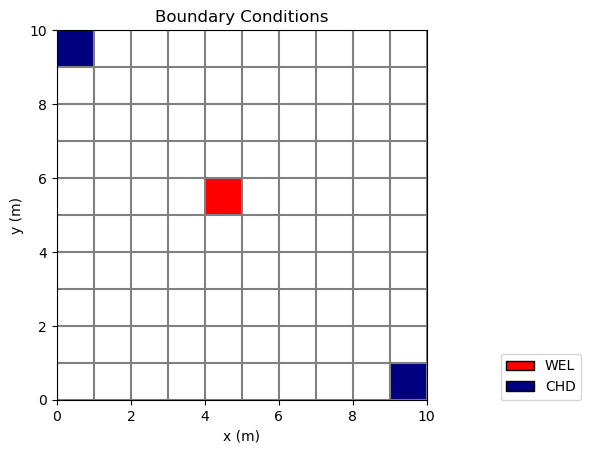

In [6]:
show_bcs(model_path=model_path, name=name, bc_names=('wel', 'chd'));

There are 4 stress periods.
The first is steady state to get consistent starting conditions.
The next three stress periods are transient:

In [7]:
%%include models/mf6/gwf_headconwell.tdis
lang = 'ini'
start_at = 'BEGIN'

```ini
BEGIN options
  TIME_UNITS  days
END options

BEGIN dimensions
  NPER  4
END dimensions

BEGIN perioddata
       1.00000000  1       1.00000000
      10.00000000  120       1.00000000
      10.00000000  120       1.00000000
      10.00000000  120       1.00000000
END perioddata
```


There is no pumping in the first, steady state stress period. 
The pumping rate varies between the following, transient, stress periods:

In [8]:
%%include models/mf6/gwf_headconwell.wel
lang = 'ini'
start_at = 'BEGIN'

```ini
BEGIN options
END options

BEGIN dimensions
  MAXBOUND  1
END dimensions

BEGIN period  2
  1 5 5 -5.00000000E-02
END period  2

BEGIN period  3
  1 5 5 -5.00000000E-01
END period  3

BEGIN period  4
  1 5 5 -5.00000000E-02
END period  4
```


In [9]:
run_simulation(model_path=model_path)

### Looking at the model results

After running the model,
we can look at the results.
This function visualizes the head at the end of the last time step: 

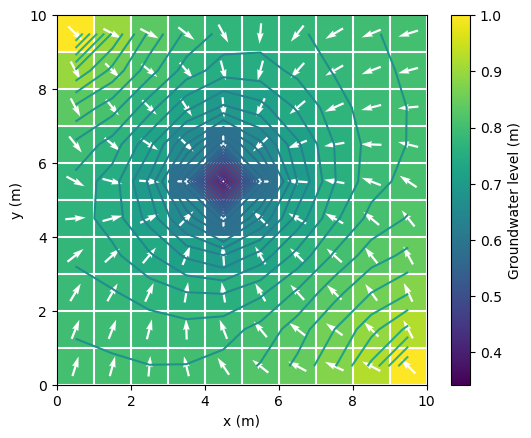

In [10]:
show_heads(model_path=model_path, name=name, title='', show_wells=True);

The well is roughly in the middle of the model.
The yellow cells have a constant water level and "feed" the model.
The well causes a cone of depression:

In [11]:
wel_coords = model_data['wells']['wel_out']['coords']

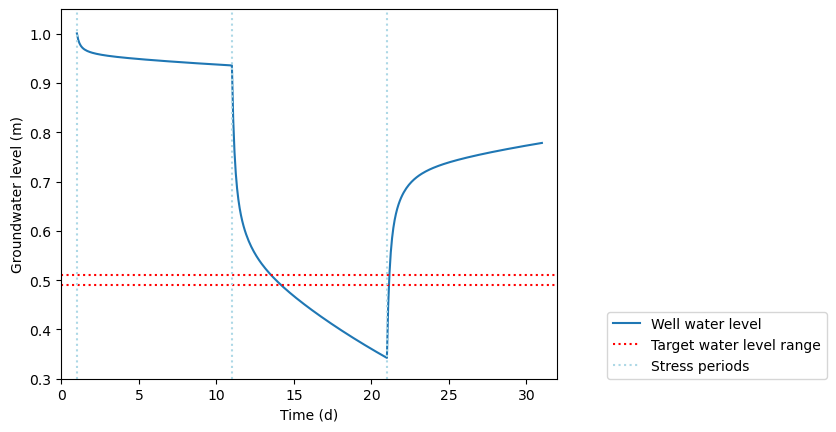

In [12]:
out = show_well_head(
    wel_coords=wel_coords, 
    model_path=model_path,
    model_name=name,
    times=model_data['times'],
    lower_head_limit=0.49, 
    upper_head_limit=0.51);

The four stress periods are indicated by the blue dotted vertical lines.
The first period, that is steady state, has only one time step.
Periods two to four are transient from day 1 to 11, 11 to 21, and 21 to 31
with different extraction rate.
The well water level reflects the pumping.
Period three has the full rate and periods two and four have only a tenth of the
rate.
The two dotted read horizontal lines show the desired mininmum well water level
of 0.5 m with a corridor of 0.01 m.

## Working with `pymf6`

Now, we will use `pymf6`.
The objective is the avoid a drop of the groundwater level at the well below a 
given limit.

In [13]:
import pandas as pd

from pymf6.modeling_tools import make_model
from pymf6.modeling_tools.base_model import make_model_data
from pymf6.modeling_tools.plotting import show_well_head

In [14]:
model_path ='models/pymf6'
name = 'headconwell'

specific_model_data = {
    'model_path': model_path,
    'name': name,
}

model_data = make_model_data(specific_model_data)

pymf6_model_data = make_model_data(specific_model_data, base_model_data=model_data)

In [15]:
wel_coords = model_data['wells']['wel_out']['coords']

In [16]:
from functools import partial

show_my_well_head = partial(show_well_head,
                            wel_coords=wel_coords,
                            lower_head_limit=0.49,
                            upper_head_limit=0.51)

Creating the input files:

In [17]:
make_model.make_input(
    pymf6_model_data
)

We run the model with `pymf6`.
We need to import the class `MF6`:

In [18]:
from pymf6.mf6 import MF6

We define variables,
holding the values for the target water level and the tolerance  that define
the limits of allowed corridor:

In [19]:
tolerance = 0.01
head_limit = 0.5
upper_limit = head_limit + tolerance
lower_limit = head_limit - tolerance

We creat and instance of the `MF6`:

In [20]:
MF6?

Init signature:
MF6(
    sim_path,
    dll_path=None,
    use_modflow_api=True,
    advance_first_step=True,
    verbose=False,
    new_step_only=False,
    do_solution_loop=True,
    _develop=False,
)
Docstring:     
Wrapper around XmiWrapper and modflowapi.

`advance_first_step = True` progresses to the first model step with
model time > 0. This is needed to access any internal values of BCs.
File:           ~/Dev/pymf6/src/pymf6/mf6.py
Type:           type
Subclasses:     

In [21]:
mf6 = MF6(model_path)

There are only flow models:

In [22]:
mf6.models.keys()

dict_keys(['gwf6'])

Get the flow models:

In [23]:
gwf_models = mf6.models['gwf6']

There is onyl one flow model:

In [24]:
gwf_models.keys()

dict_keys(['headconwell'])

We get a reference to this model:

In [25]:
gwf = gwf_models['headconwell']

These are the available packages:

In [26]:
gwf.packages

,description,is_mutable
name,,
dis,DIS Package: DIS,False
hfb,HFB Package: HFB,False
csub,CSUB Package: CSUB,False
mywell,WEL Package: MYWELL,True
mvr,MVR Package: MVR,False
ic,IC Package: IC,False
vsc,VSC Package: VSC,False
chd_0,CHD Package: CHD_0,True
buy,BUY Package: BUY,False


The well boundary condition is mutable. 
But, since no well is defined in the first, steady state, period, 
it cannot be turned into a mutable boundary condition:

In [27]:
gwf.packages.mywell.as_mutable_bc()

ValueError: No values yet.
Boundary condition MYWELL does not have any values for current stress periods.
Advance to a stress period with values and call this function again.

We get a hold of the model loop:

In [28]:
loop = mf6.model_loop()

and fast-forward to start of second time stress period:

In [29]:
for model in loop:
    if gwf.kper > 0:
        break

Now, we can create a mutable boundary condition:

In [30]:
mywell = gwf.packages.mywell.as_mutable_bc()

The well is avilable:

In [31]:
mywell

,nodelist,q
0,"(0, 4, 4)",-0.05


We can also acces the value of the pumping:

In [32]:
mywell.q[0]

np.float64(-0.05)

The well coordinates are also accessible:

In [33]:
mywell.nodelist[0]

(np.int64(0), np.int64(4), np.int64(4))

Using this coordinate,
we can get the current groundwater level in well cell:

In [34]:
gwf.X[mywell.nodelist[0]]

np.float64(1.0)

Let's create a nicer name for the coordinates

In [35]:
mywell_coords = mywell.nodelist[0]

We define a helper variable `been_below`,
that will be helpful to remember if well water level was below the defined
limit.

In [36]:
been_below = False

We use dictionary to store the modified pumping rates over time:

In [37]:
mywell_q = {'step': [], 'q': []}

Now we loop the timesteps.
We influence the pumping only in the third stress period,
i.e. when `gwf.kper` is 2:

In [38]:
for model in loop:
    if gwf.kper == 2:
        mywell_head = gwf.X[mywell_coords]
        if mywell_head <= lower_limit:
            been_below = True
            mywell.q *= 0.9
        elif been_below and mywell_head >= upper_limit:
            mywell.q *= 1.1
        mywell_q['step'].append(gwf.kstp)
        mywell_q['q'].append(mywell.q[0])

If the groundwater level in the well cell is below the given limit 
(minus the tolerance),
we set `been_below` to `True` and reduce the pumping rate by 10%.
If the cell water level was below the level before,
i.e. if `been_below` is `True`,
and the water level is above the given limit (plus the tolerance),
we increase the pumping rate by 10%.

### Looking at the results

Now the water level stays just around 0.5 m:

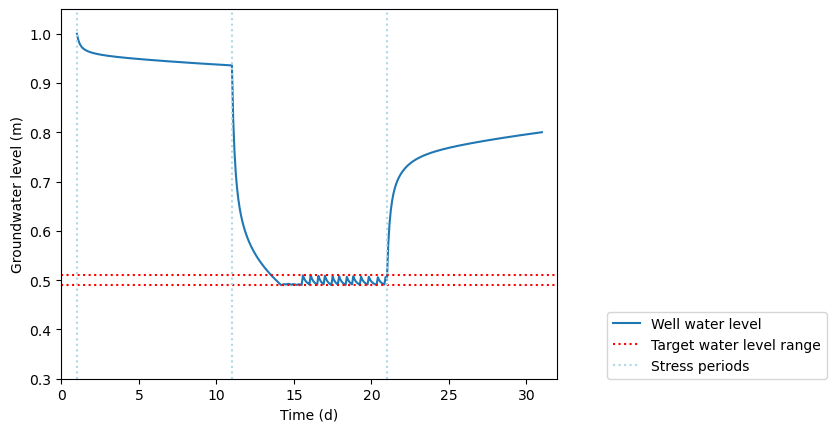

In [39]:
show_my_well_head(model_data=pymf6_model_data);

The water level oscillates tightly in the corridor between lower and upper limit. 
The pumping is modified frequently:

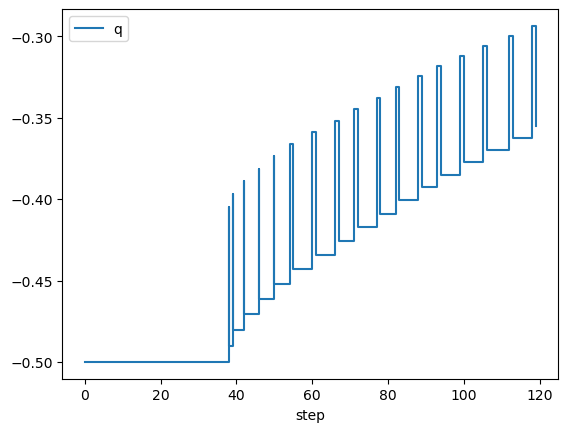

In [40]:
import pandas as pd

pd.DataFrame(mywell_q).plot(x='step');

### Further steps

The control of the pumping rate is not very realistic.
These a few things that can be done with a few lines of Python:

* Make tolerance corridor wider
* Use discrete pumping rate level instead of 10% changes